# Train Caption-en model

Goal: Extract data information from caption labels

1. Classify opening and closing parentheses and others

2. Classify letters that appear in Month description and digits

Note: We include 't' as a possible letter to avoid confusion due to 'through' 


In [1]:
import os
import sys
import json
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import re
from keras.preprocessing.image import ImageDataGenerator
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.externals import joblib

Using Theano backend.


In [2]:
proj_root = os.path.abspath(os.path.join('../')) 
datadir = os.path.join(proj_root, 'data/caption/')
modeldir = os.path.join(proj_root, 'models/')
arcdir = os.path.join(proj_root, 'models/archive')

if not os.path.isdir(datadir): 
    print('data directory not found', os.path.abspath(datadir))
    raise
if not os.path.isdir(modeldir): os.path.makedirs(modeldir)
if not os.path.isdir(modeldir): os.path.makedirs(arcdir)

In [3]:
module_path = os.path.join(proj_root, 'kgschart')
sys.path.append(module_path)
from utils import pad_image

In [4]:
X = np.load(os.path.join(datadir, 'X-en.npy'))
Y = np.load(os.path.join(datadir, 'Y-en.npy'))

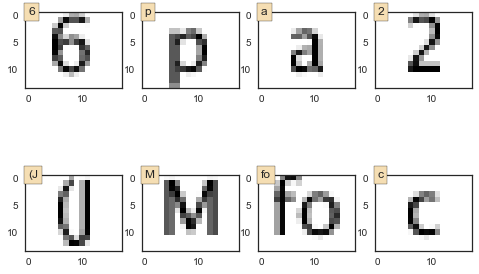

In [5]:
# convenient functions
def random_plot(X, Y, predicted=None):
    if len(Y) < 1: return
    sns.set_style('white')
    indices = np.random.choice(len(Y), min(8, len(Y)))
    count = 0
    for i in indices:
        count += 1
        ax = plt.subplot(2, 4, count)
        ax.imshow(X[i], cmap='gray')
        text = Y[i] if predicted is None else 'tr: %s, pr: %s' % (Y[i], predicted[i])
        ax.text(0, 0, text, bbox={'facecolor':"wheat"})
    plt.show(block=False)

random_plot(X, Y)


def compare_plot(X1, X2):
    sns.set_style('white')
    indices = range(3) if len(X1) <= 3 else np.random.choice(len(X1), 3)
    count = 0
    for i in indices:
        count += 1
        plt.subplot(3, 2, count)
        plt.imshow(X1[i], cmap='gray')
        count += 1
        plt.subplot(3, 2, count)
        plt.imshow(X2[i], cmap='gray')
    plt.show(block=False)

def generate_augmented_data(X, Y, target_size, seed=None):
    datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, 
                                 data_format='channels_last', channel_shift_range=0.5)
    out_X = None
    out_Y = None
    for x,y in datagen.flow(np.expand_dims(X, axis=4), Y, seed=seed):
        if out_X is None:
            out_X = x
            out_Y = y
        else:
            out_X = np.vstack([out_X, x])
            out_Y = np.concatenate([out_Y, y])
        if len(out_Y) >= target_size: 
            break
    out_X = out_X.squeeze()
    return out_X, out_Y


def diagnosis(fit, X, Y):
    print('accuracy = ', fit.score(X, Y))
    pred = fit.predict(X)
    wrong = (Y != pred)
    if np.any(wrong):
        random_plot(X[wrong], Y[wrong], pred[wrong])
    #print(classification_report(Y, pred))
    print(pd.crosstab(pd.Series(Y), pd.Series(pred), margins=True))

def ngram(x, n):
    out = set()
    for i in range(len(x)-n+1):
        item = x[i:(i+n)]
        if type(x) == str:
            out.add(item)
        else:
            out.add(tuple(item))
    return out 


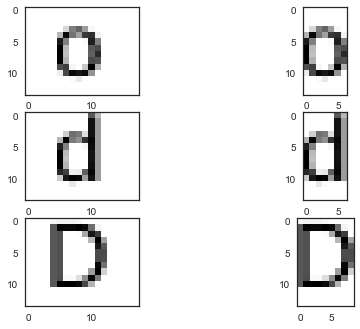

In [6]:
# remove background
def remove_background(x, bg = 1.0, rows=False, cols=True):
    """
    from a image array of size (nrow, ncol),
    remove all rows and cols where values are all bg
    """
    not_bg = (x != bg)
    non_bg_rows = np.any(not_bg, axis=1)
    non_bg_cols = np.any(not_bg, axis=0)
    
    if rows:
        tmp = non_bg_rows.nonzero()[0]
        if len(tmp) == 0: return None
        i1 = tmp[0]
        i2 = tmp[-1] + 1
    else:
        i1 = 0
        i2 = x.shape[0]
    
    if cols:
        tmp = non_bg_cols.nonzero()[0]
        if len(tmp) == 0: return None
        j1 = tmp[0]
        j2 = tmp[-1] + 1
    else:
        j1 = 0
        j2 = x.shape[1]
        
    return x[i1:i2, j1:j2]

X_nobg = [remove_background(x, rows=False) for x in X]
compare_plot(X, X_nobg)

## Train parentheses classifier

In [7]:
# obtain size of parenthesis images

max_rows = 0
max_cols = 0

for i in range(len(Y)):
    if re.search('[\(\)]', Y[i]) is not None:
        max_rows = max(X_nobg[i].shape[0], max_rows)
        max_cols = max(X_nobg[i].shape[1], max_cols)
print(max_rows, max_cols)

target_shape = (max_rows+4, max_cols+4)
print('target_shape', target_shape)

14 12
target_shape (18, 16)


total: 64, included: 64, out: 0
non-included samples
included samples


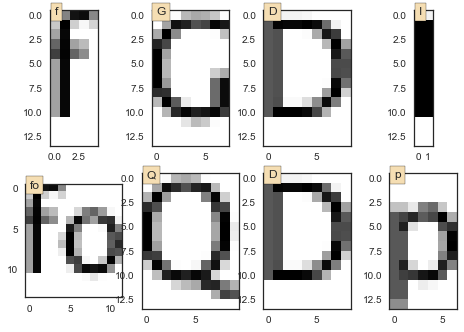

In [8]:
X_out = []
Y_out = []
X_in = []
Y_in = []
for i in range(len(Y)):
    #print(i, X_nobg[i].shape)
    if X_nobg[i].shape[0] <= target_shape[0] and X_nobg[i].shape[1] <= target_shape[1]:
        X_in.append(X_nobg[i])
        Y_in.append(Y[i])
    else:
        X_out.append(X_nobg[i])
        Y_out.append(Y[i])
print('total: %d, included: %d, out: %d' % (len(Y), len(Y_in), len(Y_out)))

print('non-included samples')
random_plot(X_out, Y_out)

print('included samples')
random_plot(X_in, Y_in)

X1 = X_in
Y1 = Y_in

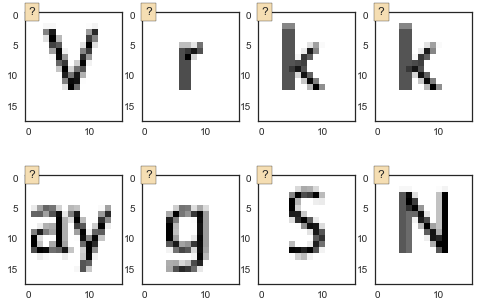

?    59
(     4
)     1
dtype: int64

In [9]:
X1 = [pad_image(x, target_shape[0], target_shape[1], 1.0) for x in X1]
X1 = [np.expand_dims(x, axis=0) for x in X1]
X1 = np.vstack(X1)

for i in range(len(Y1)):
    if Y1[i].find('(') >= 0:
        Y1[i] = '('
    elif Y1[i].find(')') >= 0:
        Y1[i] = ')'
    else:
        Y1[i] = '?'
Y1 = np.array(Y1)

random_plot(X1, Y1)
pd.Series(Y1).value_counts()

In [10]:
# generate test data from image data generator
X_test, Y_test = generate_augmented_data(X1, Y1, 10000, seed = 8)

# generate train data too
X_train, Y_train = generate_augmented_data(X1, Y1, 5000, seed = 7)

In [11]:
# used for data preprocess
class Flatten:
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X.reshape(X.shape[0], -1)
    def get_params(self, deep=True):
        return {}


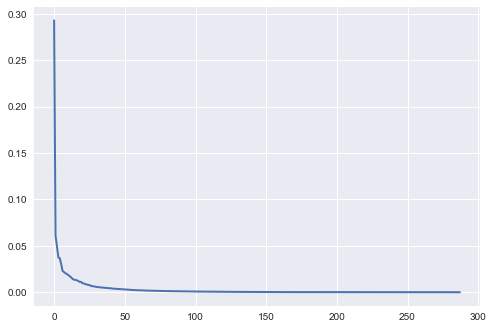

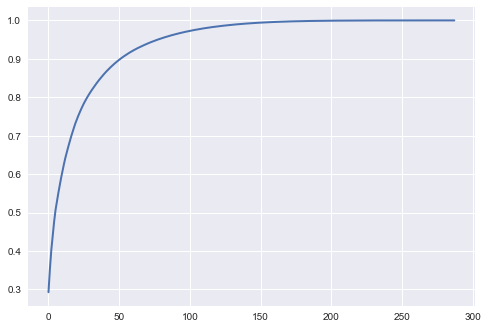

1 0.292734001022
2 0.35312250636
3 0.402854812755
4 0.44029542055
5 0.476910912864
6 0.50710074223
7 0.529992340928
8 0.551639434076
9 0.572081280026
10 0.591680509677
11 0.610105402527
12 0.627400272057
13 0.643479038962
14 0.657897461783
15 0.671396199585
16 0.68465051644
17 0.697535152778
18 0.709719541683
19 0.720916729286
20 0.732045658698
21 0.74179644304
22 0.751251064374
23 0.759964500749
24 0.76836166849
25 0.776194308712
26 0.783957672083
27 0.790794568904
28 0.797423923521
29 0.803733957746
30 0.809686685372
31 0.815372853586
32 0.820839856667
33 0.826177243072
34 0.83134823661
35 0.836413813152
36 0.841332773532
37 0.846014611293
38 0.850513885558
39 0.854939076393
40 0.859227759614
41 0.863465623774
42 0.867461735201
43 0.87127551734
44 0.874977594955
45 0.87848682442
46 0.881904757809
47 0.885302251783
48 0.888543656167
49 0.891686840735
50 0.894749725134
51 0.897655443824
52 0.900483368894
53 0.903207287782
54 0.905779830401
55 0.90826876378
56 0.910748188295
57 0.913180

In [12]:
pipe_pca = Pipeline([
    ('flatten', Flatten()), 
    ('PCA', PCA())
])

pipe_pca.fit(X_train)
sns.set()
plt.plot(pipe_pca.named_steps['PCA'].explained_variance_ratio_, linewidth=2)
plt.show(block=False)

cum = pipe_pca.named_steps['PCA'].explained_variance_ratio_.cumsum()
plt.plot(cum, linewidth=2)
plt.show(block=False)
for i in range(len(cum)):
    print(i+1, cum[i])


100 to 150

accuracy on original set =  1.0
accuracy =  0.994309105431


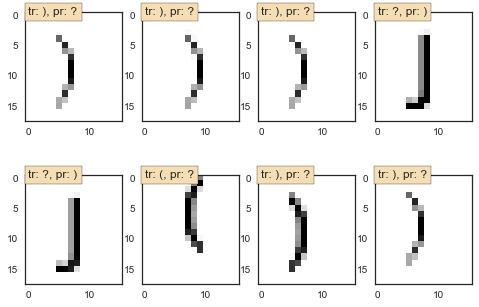

col_0    (    )     ?    All
row_0                       
(      602    0    24    626
)        0  134    23    157
?        1    9  9223   9233
All    603  143  9270  10016


In [13]:
pipe_mlp = Pipeline([
    ('flatten', Flatten()), 
    ('PCA', PCA(n_components=100)),
    ('MLP', MLPClassifier((100,100,100), alpha=0.01))
])    

pipe_mlp.fit(X_train, Y_train)


print('accuracy on original set = ', pipe_mlp.score(X1, Y1))
diagnosis(pipe_mlp, X_test, Y_test)

In [14]:
np.random.seed(87)

# create data prep pipeline and
# fit pca before learning
# this way, we can fix the features to pass to MLP
# if we use incrementalPCA and fit online, then the MLP learning would 
# mess up since there is no guarantee that PCA component i now is the 
# same as the component i in the next fitted PCA
pca = PCA(n_components=100)
pipe_prep = Pipeline([
    ('flatten', Flatten()), 
    ('PCA', pca)
])
pipe_prep.fit(X_train)

model = MLPClassifier((100,100,100), alpha=0.01, warm_start=True)
#model = MLPClassifier((100,100), alpha=0.001, warm_start=True)
pipe_pred = Pipeline([
    ('prep', pipe_prep),
    ('MLP', model)
])

classes = pipe_mlp.classes_

train_gen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, 
                               data_format='channels_last', channel_shift_range=0.1)

num = 0
result = None
counter = 0
consec_ones = 0
#for X_batch,Y_batch in train_gen.flow(np.expand_dims(X_in, axis=4), 
#                                      Y_in, batch_size=1000):
while counter <= 5000: 
    X_batch,Y_batch = generate_augmented_data(X1, Y1, 1000)
    counter += 1
    if counter > 5000: break
        
    model.partial_fit(pipe_prep.transform(X_batch.squeeze()), 
                      Y_batch, classes)
    num += len(Y_batch)
    
    score_test     = pipe_pred.score(X_test, Y_test)
    score_original = pipe_pred.score(X1, Y1)
    tmp = dict(size = [num], score_test = [score_test], 
               score_original = [score_original])
    tmp = pd.DataFrame(tmp)
    if result is None:
        result = tmp
    else:
        result = result.append(tmp)
    
    if counter % 100 == 1:
        print(num, 'score on test =', score_test,
              'score on original =', score_original)
    if score_test == 1.0 and score_original == 1.0:
        consec_ones += 1
    if consec_ones >= 10:
        print('DONE!')
        break

1024 score on test = 0.921825079872 score on original = 0.921875
103424 score on test = 0.999700479233 score on original = 1.0
205824 score on test = 0.999700479233 score on original = 1.0
DONE!


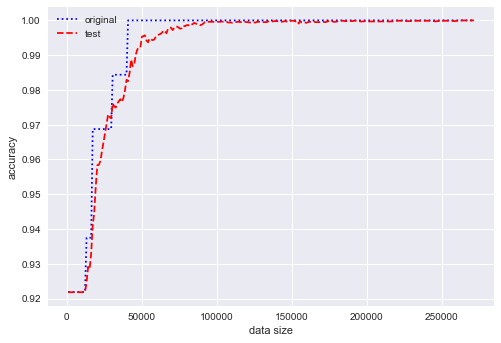

In [15]:
sns.set()
plt.plot(result['size'], result['score_original'], 'b:', label='original')
plt.plot(result['size'], result['score_test'], 'r--', label='test') 
plt.legend()
plt.ylabel('accuracy')
plt.xlabel('data size')
plt.show(block=False)

In [16]:
savename = os.path.join(modeldir, 'caption-en-paren_pca-mlp-full.pkl')
pipe = Pipeline([('PCA', pca), ('MLP', model)])
joblib.dump(pipe, savename)

['/home/kota/Documents/kgschart/models/caption-en-paren_pca-mlp-full.pkl']

In [17]:
with open(os.path.join(modeldir, 'caption-en-paren-config.json'), 'w') as file:
    json.dump(dict(input_shape=X1.shape[1:]), file)

## Classification of date-relevant letters

In [18]:
# obtain size of date relevant images images

max_rows = 0
max_cols = 0

for i in range(len(Y)):
    if re.search('[JanFebMarAprMayJunJulIAugSepOctNovDec0-9\(\),t]', Y[i]) is not None:
        max_rows = max(X_nobg[i].shape[0], max_rows)
        max_cols = max(X_nobg[i].shape[1], max_cols)
print(max_rows, max_cols)

target_shape = (max_rows+4, max_cols+4)
print('target_shape', target_shape)

14 14
target_shape (18, 18)


total: 64, included: 64, out: 0
non-included samples
included samples


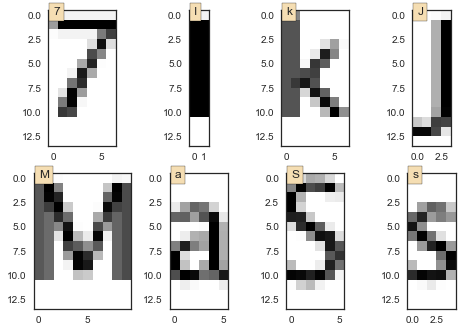

In [19]:
X_out = []
Y_out = []
X_in = []
Y_in = []
for i in range(len(Y)):
    #print(i, X_nobg[i].shape)
    if X_nobg[i].shape[0] <= target_shape[0] and X_nobg[i].shape[1] <= target_shape[1]:
        X_in.append(X_nobg[i])
        Y_in.append(Y[i])
    else:
        X_out.append(X_nobg[i])
        Y_out.append(Y[i])
print('total: %d, included: %d, out: %d' % (len(Y), len(Y_in), len(Y_out)))

print('non-included samples')
random_plot(X_out, Y_out)

print('included samples')
random_plot(X_in, Y_in)

X2 = X_in
Y2 = Y_in

n, J, a, e, F, b, r, M, a, r, p, A, y, M, a, n, u, J, u, J, l, u, I, J, u, A, g, p, e, S, t, c, O, o, N, v, e, c, D, an, Ja, eb, Fe, Ma, ar, pr, Ap, ay, Ma, Ju, un, ul, Ju, uI, Ju, ug, Au, Se, ep, Oc, ct, ov, No, De, ec, (J, (F, (M, (A, (M, (J, (J, (J, (A, (S, (O, (N, (D, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, (, ), ,, t, th


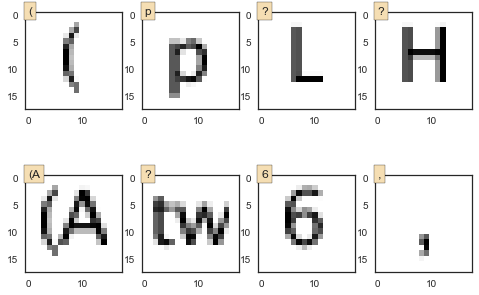

?     23
(J     2
S      1
6      1
o      1
5      1
9      1
N      1
3      1
u      1
n      1
ov     1
b      1
8      1
7      1
r      1
t      1
4      1
e      1
(      1
1      1
(A     1
A      1
a      1
F      1
J      1
O      1
p      1
l      1
v      1
y      1
D      1
2      1
)      1
c      1
g      1
M      1
I      1
ay     1
0      1
,      1
dtype: int64

In [20]:
X2 = [pad_image(x, target_shape[0], target_shape[1], 1.0) for x in X2]
X2 = [np.expand_dims(x, axis=0) for x in X2]
X2 = np.vstack(X2)


month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'JuI', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

month1 = sum([list(ngram(x, 1)) for x in month_names], [])
month2 = sum([list(ngram(x, 2)) for x in month_names], [])
month3 = ['(' + x[0] for x in month_names]
dig_sym = [s for s in '0123456789(),']

date_relevant = month1 + month2 + month3 + dig_sym + ['t', 'th']
print(', '.join(date_relevant))

Y2 = [y if y in date_relevant else '?' for y in Y2]
Y2 = np.array(Y2)

random_plot(X2, Y2)
pd.Series(Y2).value_counts()

In [21]:
# generate test data from image data generator
X_test, Y_test = generate_augmented_data(X2, Y2, 10000, seed = 8)

# generate train data too
X_train, Y_train = generate_augmented_data(X2, Y2, 5000, seed = 7)

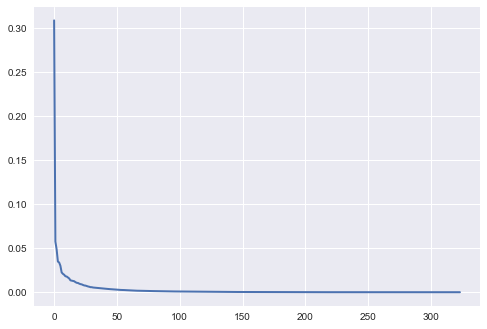

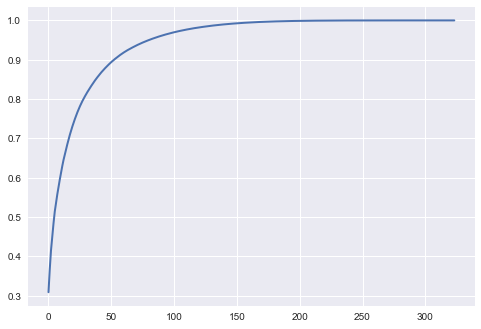

1 0.309129913548
2 0.366787217344
3 0.415471708357
4 0.450326269172
5 0.484153461416
6 0.514248195112
7 0.536743256746
8 0.557627216805
9 0.57748187502
10 0.595641251737
11 0.613478240793
12 0.630190999532
13 0.645822275672
14 0.659327762274
15 0.672533268518
16 0.685310059509
17 0.69778708549
18 0.709217171516
19 0.719916263214
20 0.730404634655
21 0.740128057725
22 0.749300267281
23 0.758198783964
24 0.766416263366
25 0.774102497068
26 0.781602534301
27 0.78859727417
28 0.795126782592
29 0.80132244764
30 0.807050427321
31 0.812747256043
32 0.818096354255
33 0.823293602837
34 0.828361567221
35 0.833299316558
36 0.838162695237
37 0.842845403904
38 0.847380548598
39 0.851751753456
40 0.855892063618
41 0.859989583457
42 0.863999290665
43 0.867817832451
44 0.871444093404
45 0.874999285744
46 0.878418924874
47 0.881727698099
48 0.884962154427
49 0.888126480528
50 0.891171462486
51 0.894090049353
52 0.896870808862
53 0.899635425066
54 0.90222402648
55 0.904736818625
56 0.907229143345
57 0.9

In [22]:
pipe_pca = Pipeline([
    ('flatten', Flatten()), 
    ('PCA', PCA())
])

pipe_pca.fit(X_train)
sns.set()
plt.plot(pipe_pca.named_steps['PCA'].explained_variance_ratio_, linewidth=2)
plt.show(block=False)

cum = pipe_pca.named_steps['PCA'].explained_variance_ratio_.cumsum()
plt.plot(cum, linewidth=2)
plt.show(block=False)
for i in range(len(cum)):
    print(i+1, cum[i])


accuracy on original set =  1.0
accuracy =  0.953174920128


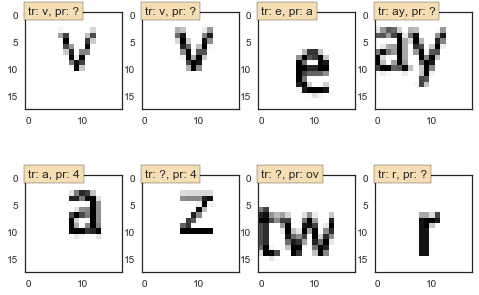

col_0    (   (A   (J    )    ,    0    1    2    3    4  ...      n    o   ov  \
row_0                                                    ...                    
(      152    0    0    0    0    0    0    0    0    0  ...      0    0    0   
(A       0  148    0    0    0    0    0    0    0    0  ...      0    0    7   
(J       0    0  310    0    0    0    0    0    0    0  ...      0    0    0   
)        0    0    0  145    0    0    0    0    0    0  ...      0    0    0   
,        0    0    0    0  156    0    0    0    0    0  ...      0    0    0   
0        0    0    0    0    0  153    0    0    0    0  ...      0    0    0   
1        0    0    0    0    0    0  153    0    0    0  ...      0    0    0   
2        0    0    0    0    0    0    0  154    0    0  ...      0    0    0   
3        0    0    0    0    0    0    3    2  145    0  ...      0    0    0   
4        0    0    0    0    0    0    0    0    0  148  ...      0    0    0   
5        0    0    0    0   

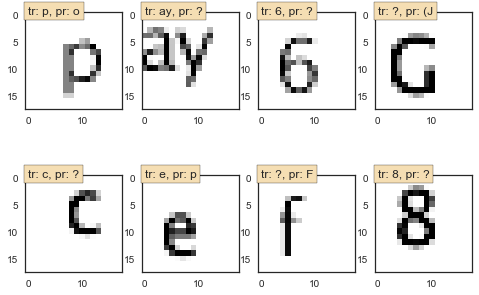

col_0    (   (A   (J    )    ,    0    1    2    3    4  ...      n    o   ov  \
row_0                                                    ...                    
(      152    0    0    0    0    0    0    0    0    0  ...      0    0    0   
(A       0  148    0    0    0    0    0    0    0    0  ...      0    0    7   
(J       0    0  310    0    0    0    0    0    0    0  ...      0    0    0   
)        0    0    0  145    0    0    0    0    0    0  ...      0    0    0   
,        0    0    0    0  156    0    0    0    0    0  ...      0    0    0   
0        0    0    0    0    0  153    0    0    0    0  ...      0    0    0   
1        0    0    0    0    0    0  153    0    0    0  ...      0    0    0   
2        0    0    0    0    0    0    0  154    0    0  ...      0    0    0   
3        0    0    0    0    0    0    3    2  145    0  ...      0    0    0   
4        0    0    0    0    0    0    0    0    0  148  ...      0    0    0   
5        0    0    0    0   

In [23]:
pipe_mlp = Pipeline([
    ('flatten', Flatten()), 
    ('PCA', PCA(n_components=100)),
    ('MLP', MLPClassifier((100,100,100), alpha=0.01))
])    

pipe_mlp.fit(X_train, Y_train)


print('accuracy on original set = ', pipe_mlp.score(X2, Y2))
diagnosis(pipe_mlp, X_test, Y_test)
diagnosis(pipe_mlp, X_test, Y_test)

In [24]:
np.random.seed(87)

# create data prep pipeline and
# fit pca before learning
# this way, we can fix the features to pass to MLP
# if we use incrementalPCA and fit online, then the MLP learning would 
# mess up since there is no guarantee that PCA component i now is the 
# same as the component i in the next fitted PCA
pca = PCA(n_components=100)
pipe_prep = Pipeline([
    ('flatten', Flatten()), 
    ('PCA', pca)
])
pipe_prep.fit(X_train)

#model = MLPClassifier((100,100,100), alpha=0.001, warm_start=True)
model = MLPClassifier((100,100), alpha=0.001, warm_start=True)
pipe_pred = Pipeline([
    ('prep', pipe_prep),
    ('MLP', model)
])

classes = pipe_mlp.classes_


num = 0
result = None
counter = 0
consec_ones = 0
#for X_batch,Y_batch in train_gen.flow(np.expand_dims(X_in, axis=4), 
#                                      Y_in, batch_size=1000):
while counter <= 5000: 
    X_batch,Y_batch = generate_augmented_data(X2, Y2, 1000)
    counter += 1
    if counter > 5000: break
        
    model.partial_fit(pipe_prep.transform(X_batch.squeeze()), 
                      Y_batch, classes)
    num += len(Y_batch)
    
    score_test     = pipe_pred.score(X_test, Y_test)
    score_original = pipe_pred.score(X2, Y2)
    tmp = dict(size = [num], score_test = [score_test], 
               score_original = [score_original])
    tmp = pd.DataFrame(tmp)
    if result is None:
        result = tmp
    else:
        result = result.append(tmp)
    
    if counter % 100 == 1:
        print(num, 'score on test =', score_test,
              'score on original =', score_original)
    if score_test == 1.0 and score_original == 1.0:
        consec_ones += 1
    if consec_ones >= 10:
        print('DONE!')
        break

1024 score on test = 0.190994408946 score on original = 0.203125
103424 score on test = 0.900559105431 score on original = 0.984375
205824 score on test = 0.980830670927 score on original = 1.0
308224 score on test = 0.995607028754 score on original = 1.0
410624 score on test = 0.997004792332 score on original = 1.0
513024 score on test = 0.998801916933 score on original = 1.0
615424 score on test = 0.997703674121 score on original = 1.0
717824 score on test = 0.998901757188 score on original = 1.0
820224 score on test = 0.998602236422 score on original = 1.0
922624 score on test = 0.998602236422 score on original = 1.0
1025024 score on test = 0.998502396166 score on original = 1.0
1127424 score on test = 0.999400958466 score on original = 1.0
1229824 score on test = 0.999301118211 score on original = 1.0
1332224 score on test = 0.998402555911 score on original = 1.0
1434624 score on test = 0.998702076677 score on original = 1.0
1537024 score on test = 0.998901757188 score on original 

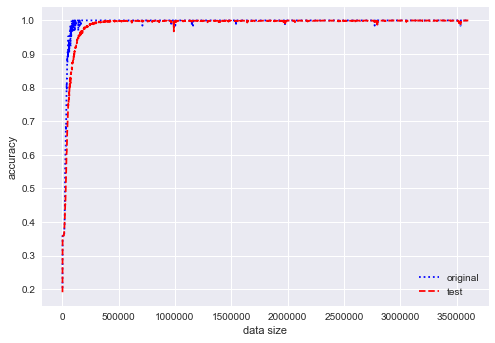

In [25]:
sns.set()
plt.plot(result['size'], result['score_original'], 'b:', label='original')
plt.plot(result['size'], result['score_test'], 'r--', label='test') 
plt.legend()
plt.ylabel('accuracy')
plt.xlabel('data size')
plt.show(block=False)

In [26]:
savename = os.path.join(modeldir, 'caption-en-letter_pca-mlp-full.pkl')
pipe = Pipeline([('PCA', pca), ('MLP', model)])
joblib.dump(pipe, savename)

['/home/kota/Documents/kgschart/models/caption-en-letter_pca-mlp-full.pkl']

In [27]:
with open(os.path.join(modeldir, 'caption-en-letter-config.json'), 'w') as file:
    json.dump(dict(input_shape=X2.shape[1:]), file)